In [1]:
import numpy as np
print(np.__version__)


import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

from tqdm.notebook import trange

import random
import math

1.23.4
2.0.0+cu118


In [3]:
class Santorini:
    def __init__(self):
        self.row_count = 5
        self.column_count = 5
        self.action_size = 128
        
        self.adjacent = [(-1,-1), (-1, 0), (-1, 1), (0, -1), (0,  1), (1, -1), (1,  0), (1,  1)]

        ################### BASIC BOARD SETUP - did not yet implement placing the pawns ###################
        self.start_board = np.array([[0 for _ in range(5)] for _ in range(5)])
        self.start_board[1, 1] = 110
        self.start_board[3, 3] = 120
        self.start_board[1, 3] = -110
        self.start_board[3, 1] = -120
        ###################################################################################################

    def __repr__(self):
        return "Santorini"
    
    def get_initial_state(self):
        return self.start_board.copy()
    
    def get_next_state(self, state, action, player):
        index, move, build = self.readable_action_format(action)
        piece_position = self.find_pawn_pos(state, player, index)
        move_position = (piece_position[0] + self.adjacent[move][0], piece_position[1] + self.adjacent[move][1])
        build_position = (move_position[0] + self.adjacent[build][0], move_position[1] + self.adjacent[build][1])

        state[move_position] = player * (abs(state[piece_position]) // 10 * 10 + state[move_position])
        state[piece_position] = abs(state[piece_position]) % 10
        state[build_position] = state[build_position] + 1
        return state
    
    def get_valid_moves(self, state):
        pieces = self.find_player_pawns(state, 1)
        actions = np.zeros(128)
        for piece_position in pieces:
            piece_index = state[piece_position] // 10 % 10 - 1
            for move in range(8):
                move_position = (piece_position[0] + self.adjacent[move][0], piece_position[1] + self.adjacent[move][1])

                # check if valid move
                if ((move_position[0] >= 0 and move_position[0] <= 4 and move_position[1] >= 0 and move_position[1] <= 4)   # valid cell
                        and (state[move_position] >= 0 and state[move_position] < 4)                                        # not occupied / dome
                        and state[move_position] - abs(state[piece_position]) % 10 <= 1):                                   # not too tall
                    
                    for build in range(8):
                        build_position = (move_position[0] + self.adjacent[build][0], move_position[1] + self.adjacent[build][1])
                        if build_position[0] >= 0 and build_position[0] <= 4 and build_position[1] >= 0 and build_position[1] <= 4:
                            if (state[build_position] >= 0 and state[build_position] < 4) or build_position == piece_position:
                                actions[self.machine_action_format(piece_index, move, build)] = 1
        return actions
    
    def check_win(self, state, action, enemy_player=1):
        if action == None:
            return False
        
        winners = [element for _, element in np.ndenumerate(state) if abs(element) > 100 and abs(element) % 10 == 3]
        if len(winners) > 0 or self.no_possible_moves(state, player=enemy_player):
            return True
        return False
        
    def get_value_and_terminated(self, state, action, player=-1):
        if self.check_win(state, action, enemy_player=self.get_opponent(player)):
            return 1, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return np.where(abs(state) < 100, state, state*player)
    
    def get_encoded_state(self, state):
        encoded_neg_player = np.where(state < -100, abs(state) // 10 % 10, 0)
        encoded_builds = np.where(abs(state) <= 4, state - (state//4)*5, 0)
        encoded_pos_player = np.where(state > 100, state // 10 % 10, 0)

        encoded_state = np.stack(
            (encoded_neg_player, encoded_builds, encoded_pos_player)
        ).astype(np.float32)
        
        return encoded_state
        
    ############################################################ own functions:
    
    def no_possible_moves(self, state, player):
        pieces = self.find_player_pawns(state, player)
        for piece_position in pieces:
            for move in range(8):
                move_position = (piece_position[0] + self.adjacent[move][0], piece_position[1] + self.adjacent[move][1])

                # check if valid move
                if ((move_position[0] >= 0 and move_position[0] <= 4 and move_position[1] >= 0 and move_position[1] <= 4)   # valid cell
                        and state[move_position] >= 0 and state[move_position] < 4                                          # not occupied / dome
                        and state[move_position] - abs(state[piece_position]) % 10 <= 1):                                   # not too tall
                    return False
        return True

    def readable_action_format(self, number):
        index = number // 64
        number = number % 64
        move = number // 8
        number = number % 8
        build = number
        return (index, move, build)
    
    def machine_action_format(self, piece_index, move, build):
        return piece_index * 64 + move * 8 + build
    
    def find_pawn_pos(self, state, player, index):
        position = [idx for idx, element in np.ndenumerate(state) if abs(element) > 100 and player * element > 0 and abs(element) // 10 % 10 == (index+1) ]
        return position[0]
        
    def find_player_pawns(self, state, player):
        return [idx for idx, element in np.ndenumerate(state) if player*element > 100]

In [4]:
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count
        
    def __repr__(self):
        return "TicTacToe"
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]
        
        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

In [5]:
class ConnectFour:
    def __init__(self):
        self.row_count = 6
        self.column_count = 7
        self.action_size = self.column_count
        self.in_a_row = 4
        
    def __repr__(self):
        return "ConnectFour"
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = np.max(np.where(state[:, action] == 0))
        state[row, action] = player
        return state
    
    def get_valid_moves(self, state):
        return (state[0] == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = np.min(np.where(state[:, action] != 0))
        column = action
        player = state[row][column]

        def count(offset_row, offset_column):
            for i in range(1, self.in_a_row):
                r = row + offset_row * i
                c = action + offset_column * i
                if (
                    r < 0 
                    or r >= self.row_count
                    or c < 0 
                    or c >= self.column_count
                    or state[r][c] != player
                ):
                    return i - 1
            return self.in_a_row - 1

        return (
            count(1, 0) >= self.in_a_row - 1 # vertical
            or (count(0, 1) + count(0, -1)) >= self.in_a_row - 1 # horizontal
            or (count(1, 1) + count(-1, -1)) >= self.in_a_row - 1 # top left diagonal
            or (count(1, -1) + count(-1, 1)) >= self.in_a_row - 1 # top right diagonal
        )
    
    def get_value_and_terminated(self, state, action, player=0):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

In [6]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()
        
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )
        
        self.to(device)
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
        
        
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x
        

In [7]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
        
        self.visit_count = visit_count
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        child = None
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
                
        return None
            
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state, visit_count=1)
        
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)
        
        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        
        for search in range(self.args['num_searches']):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                
                value = value.item()
                
                node.expand(policy)
                
            node.backpropagate(value)    
            
            
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
        

In [8]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)
        
    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        
        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)
            
            memory.append((neutral_state, action_probs, player))
            
            temperature_action_probs = action_probs ** (1 / self.args['temperature'])
            temperature_action_probs /= np.sum(temperature_action_probs)
            action = np.random.choice(self.game.action_size, p=temperature_action_probs)
            
            state = self.game.get_next_state(state, action, player)
            
            value, is_terminal = self.game.get_value_and_terminated(state, action, player=player)
            
            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            player = self.game.get_opponent(player)
                
    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()
                
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"test_model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"test_optimizer_{iteration}_{self.game}.pt")

In [31]:
game = Santorini()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(game, 9, 256, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 500,
    'num_iterations': 8,
    'num_selfPlay_iterations': 200,
    'num_parallel_games': 100,
    'num_epochs': 4,
    'batch_size': 128,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZero(model, optimizer, game, args)
alphaZero.learn()

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

[[   0    0    0    0    0]
 [   0  110    1    1    0]
 [   0    0 -110  122    0]
 [   0    1    0    3    0]
 [   0 -120    1    0    0]]
expected (52) : 0.0017213871469721198 - (0, 6, 4)
instead the max is 100 : 0.0552792064845562 - (1, 4, 4)


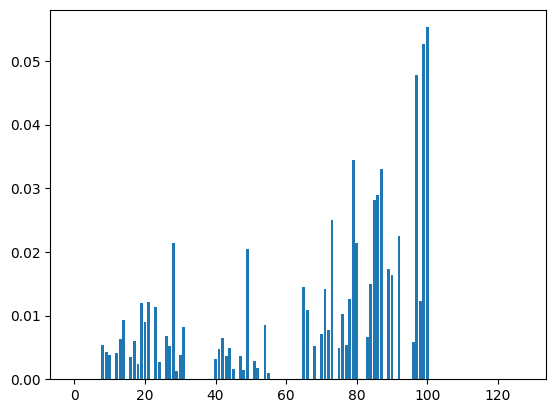

In [9]:
import matplotlib.pyplot as plt

santorini = Santorini()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state = santorini.get_initial_state()
state = santorini.get_next_state(state, 71, 1)
state = santorini.get_next_state(state, 28, -1)
state = santorini.get_next_state(state, 121, 1)
state = santorini.get_next_state(state, 49, -1)
state = santorini.get_next_state(state, 78, 1)
state = santorini.get_next_state(state, 120, -1)
state = santorini.get_next_state(state, 113, 1)
state = santorini.get_next_state(state, 92, -1)
state = santorini.get_next_state(state, 78, 1)

# this is the expected move to block the positive player from stepping down on to the level3 building
expected = santorini.machine_action_format(0, 6, 4)


neutral_state = santorini.change_perspective(state, -1)
encoded_state = santorini.get_encoded_state(neutral_state)
tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet(santorini, 9, 256, device=device)
# here going through the models 0 -> 3 we can see that the expected action's policy keeps going down
model.load_state_dict(torch.load('model_1_Santorini.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()
possible = santorini.get_valid_moves(neutral_state)
policy *= possible

# print(value)
print(state)

print(f"expected ({expected}) : {policy[expected]} - {santorini.readable_action_format(expected)}")
max_a = np.argmax(policy)
print(f"instead the max is {max_a} : {policy[max_a]} - {santorini.readable_action_format(max_a)}")


plt.bar(range(santorini.action_size), policy)
plt.show()